# Building gradients
## Set the enviroment

In [72]:
# python notebook
#
# Tutorial 3 - Building gradients
# micapipe v0.1.1
#
# Created by RRC on September 2021 (the second year of the pademic)

# Set the environment
import os
import numpy as np
import nibabel as nb
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt

# Set the working directory to the 'out' directory
os.chdir("~/out")     # <<<<<<<<<<<< CHANGE THIS PATH

# Path to micapipe repository
micapipe='~/micapipe' # <<<<<<<<<<<< CHANGE THIS PATH

# This variable will be different for each subject
subjectID='sub-HC001_ses-01'           # <<<<<<<<<<<< CHANGE THIS SUBJECT's ID
subjectDir='micapipe/sub-HC001/ses-01' # <<<<<<<<<<<< CHANGE THIS SUBJECT's DIRECTORY

# Here we define the atlas 
atlas='schaefer-400' # <<<<<<<<<<<< CHANGE THIS ATLAS

## Load the surfaces

In [79]:
# Load conte69
c69_lh, c69_rh = load_conte69()

# Load fsaverage5
fs5_lh = read_surface('freesurfer/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface('freesurfer/fsaverage5/surf/rh.pial', itype='fs')

# Load annotation file in fsaverage5
annot_lh_fs5= nb.freesurfer.read_annot(micapipe + '/parcellations/lh.schaefer-400_mics.annot')
annot_rh_fs5= nb.freesurfer.read_annot(micapipe + '/parcellations/rh.schaefer-400_mics.annot')[0]+200

# replace with 0 the medial wall of the right labels
annot_rh_fs5 = np.where(annot_rh_fs5==200, 0, annot_rh_fs5) 

# fsaverage5 labels
labels_fs5 = np.concatenate((annot_lh_fs5[0], annot_rh_fs5), axis=0)

# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/schaefer-400_conte69.csv'), dtype=np.int)


# Functional gradients
## Load and slice the functional matrix

In [124]:
# Load the cortical connectome
mtx_fs = np.loadtxt(subjectDir + '/func/surfaces/' + subjectID + '_rsfmri_space-fsnative_atlas-' + atlas + '_desc-FC.txt', 
                    dtype=np.float, delimiter=' ')

# slice the matrix
FC = mtx_fs[49:, 49:]
FC = np.delete(np.delete(FC, 200, axis=0), 200, axis=1)

# Fischer transformation
FCz = np.arctanh(FC)

# replace inf with 0
FCz[~np.isfinite(FCz)] = 0

# Mirror the matrix
FCz = np.triu(FCz,1)+FCz.T

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

divide by zero encountered in arctanh



## Calculate the functional gradients

In [148]:
# Number of gradients
N = 10

# Calculate the gradients
gm = GradientMaps(n_components=N, random_state=None, approach='dm', kernel='normalized_angle')
gm.fit(FCz, sparsity=0.8)

GradientMaps(kernel='normalized_angle')

## Plot the functional gradients

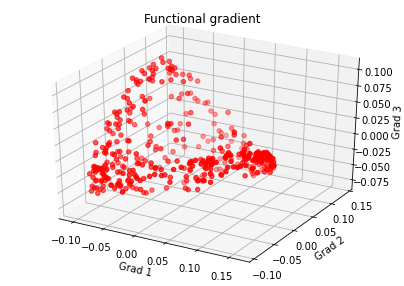

In [149]:
# Plot the gradients
g1=gm.gradients_[:, 0]
g2=gm.gradients_[:, 1]
g3=gm.gradients_[:, 2]

# Creating figure
fig = plt.subplots(1, 2, figsize = (7, 5))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(g1, g2, g3, color = 'red')
plt.title("Functional gradient")
ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')
 
# show plot
plt.show()

## Functional gradients to fsaverage5 surface

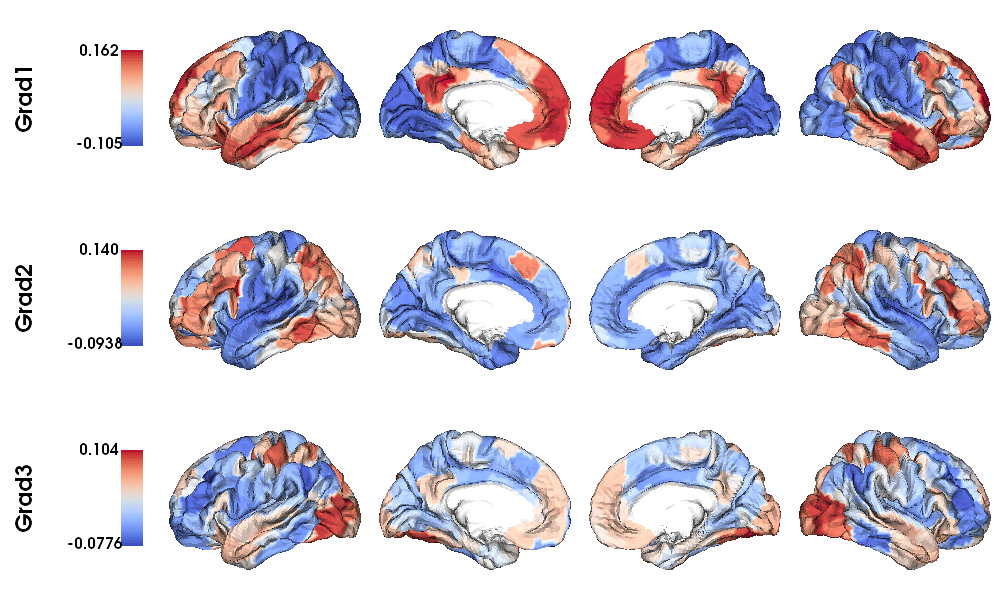

In [152]:
# Mask of the medial wall on fsaverage 5
mask_fs5 = labels_fs5 != 0

# Map gradients to original parcels
grad = [None] * 3
for i, g in enumerate(gm.gradients_.T[0:3,:]):
    grad[i] = map_to_labels(g, labels_fs5,  fill=np.nan, mask=mask_fs5)

# Plot Gradients RdYlBu
plot_hemispheres(fs5_lh, fs5_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':['Grad1', 'Grad2','Grad3']}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1) )

## Functional gradients to conte69 surface

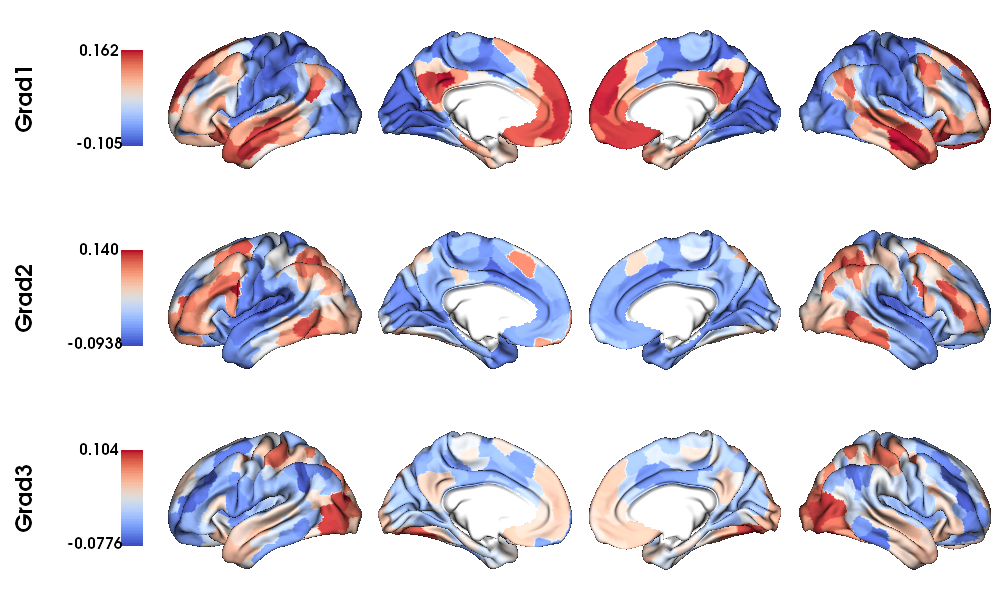

In [153]:
# mask of the medial wall
mask_c69 = labels_c69 != 0

# Map gradients to original parcels
grad = [None] * 3
for i, g in enumerate(gm.gradients_.T[0:3,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)

# Plot Gradients coolwarm
plot_hemispheres(c69_lh, c69_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':['Grad1', 'Grad2','Grad3']}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1))

# Structural gradients
## Load and slice the structural matrix

In [154]:
# Load the cortical connectome
mtx_sc = np.loadtxt(subjectDir + '/dwi/connectomes/' + subjectID + '_space-dwi_atlas-' + atlas + '_desc-iFOD2-40M-SIFT2_cor-connectome.txt', 
                    dtype=np.float, delimiter=' ')

# Fill the lower triangle of the matrix
mtx_sc = np.log(np.triu(mtx_sc,1)+mtx_sc.T)
mtx_sc[np.isneginf(mtx_sc)] = 0

# Slice the connectome to use only cortical nodes
SC = mtx_sc[49:, 49:]
SC = np.delete(np.delete(SC, 200, axis=0), 200, axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

divide by zero encountered in log



## Calculate the structural gradients

In [155]:
# SC Left hemi
gm_SC_L = GradientMaps(n_components=N, random_state=None, approach='dm', kernel='normalized_angle')
gm_SC_L.fit(SC[0:200, 0:200], sparsity=0)

# SC Right hemi
gm_SC_R = GradientMaps(n_components=N, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
gm_SC_R.fit(SC[200:400, 200:400], sparsity=0, reference=gm_SC_L.gradients_)

GradientMaps(alignment='procrustes', kernel='normalized_angle')

## Plot the structural gradients

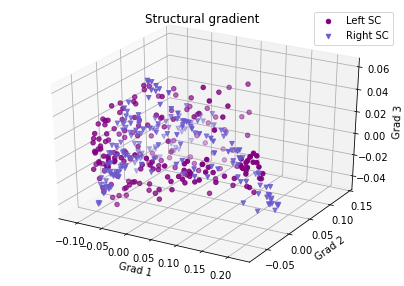

In [156]:
# plot the left gradients
g1=gm_SC_L.gradients_[:, 0]
g2=gm_SC_L.gradients_[:, 1]
g3=gm_SC_L.gradients_[:, 2]
# plot the right gradients
g1R=gm_SC_R.gradients_[:, 0]
g2R=gm_SC_R.gradients_[:, 1]
g3R=gm_SC_R.gradients_[:, 2]

# Creating figure
fig = plt.subplots(1, 2, figsize = (7, 5))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(g1, g2, g3, color = 'purple')
ax.scatter3D(g1R, g2R, g3R, color = 'slateblue', marker='v')
plt.title("Structural gradient")
ax.legend(['Left SC', 'Right SC'])
ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')
 
# show plot
plt.show()

## Structural gradients to conte69 surface

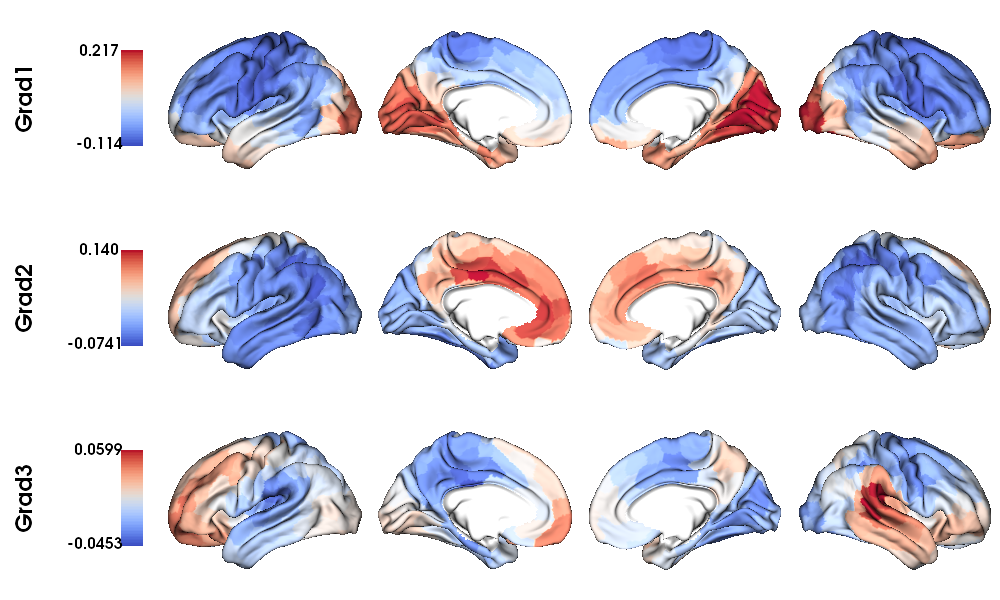

In [157]:
# Left and right gradients concatenated
SC_gradients = np.concatenate((gm_SC_L.gradients_, gm_SC_R.gradients_), axis=0)

# Map gradients to original parcels
grad = [None] * 3
for i, g in enumerate(SC_gradients.T[0:3,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)

# Plot Gradients
plot_hemispheres(c69_lh, c69_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':['Grad1', 'Grad2','Grad3']}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1) )

# MPC gradients
## Load and slice the MPC matrix

In [158]:
# Load the cortical connectome
mtx_mpc = np.loadtxt(subjectDir + '/anat/surfaces/micro_profiles/' + subjectID + '_space-fsnative_atlas-' + atlas + '_desc-MPC.txt', 
                     dtype=np.float, delimiter=' ')

# Fill the lower triangle of the matrix
MPC = np.triu(mtx_mpc,1)+mtx_mpc.T

# Renove the medial wall
MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
MPC = np.delete(np.delete(MPC, 200, axis=0), 200, axis=1)

## Calculate the MPC gradients

In [159]:
# Calculate the grandients
gm = GradientMaps(n_components=15, random_state=None, approach='dm', kernel='normalized_angle')
gm.fit(MPC, sparsity=0.8)

GradientMaps(kernel='normalized_angle', n_components=15)

## Plot the MPC gradients

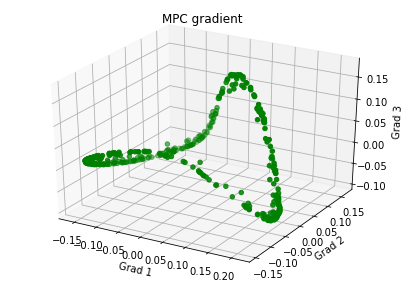

In [176]:
# Plot the gradients
g1=gm.gradients_[:, 0]
g2=gm.gradients_[:, 1]
g3=gm.gradients_[:, 2]

# Creating figure
fig = plt.subplots(1, 2, figsize = (7, 5))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(g1, g2, g3, color = 'green')
plt.title("MPC gradient")
ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')
 
# show plot
plt.show()

## MPC gradients to conte69 surface

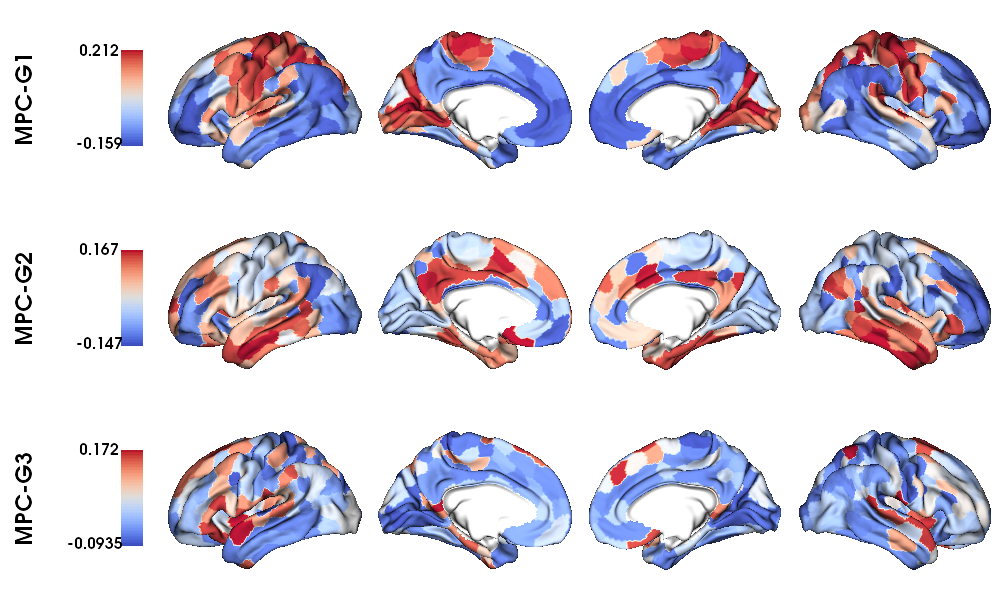

In [161]:
# Map gradients to original parcels
grad = [None] * 3
for i, g in enumerate(gm.gradients_.T[0:3,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)

# Plot Gradients
plot_hemispheres(c69_lh, c69_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':['MPC-G1', 'MPC-G2','MPC-G3']}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1) )

# Geodesic distance
## Load and slice the GD matrix

In [171]:
# Load the cortical connectome
mtx_gd = np.loadtxt(subjectDir + '/anat/surfaces/geo_dist/' + subjectID + '_space-fsnative_atlas-' + atlas + '_GD.txt', 
                    dtype=np.float, delimiter=' ')

# Remove the Mediall Wall
mtx_gd = np.delete(np.delete(mtx_gd, 0, axis=0), 0, axis=1)
GD = np.delete(np.delete(mtx_gd, 200, axis=0), 200, axis=1)

## Calculate the GD gradients

In [172]:
# GD Left hemi
gm_GD_L = GradientMaps(n_components=N, random_state=None, approach='dm', kernel='normalized_angle')
gm_GD_L.fit(GD[0:200, 0:200], sparsity=0.8)

# GD Right hemi
gm_GD_R = GradientMaps(n_components=N, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
gm_GD_R.fit(GD[200:400, 200:400], sparsity=0.8, reference=gm_GD_L.gradients_)

GradientMaps(alignment='procrustes', kernel='normalized_angle')

## Plot the GD gradients

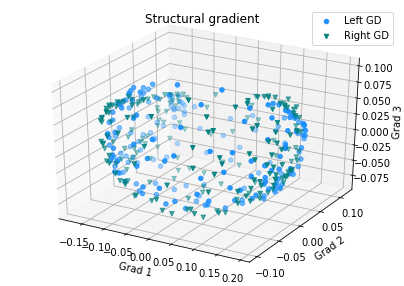

In [173]:
# plot the gradients
g1=gm_GD_L.gradients_[:, 0]
g2=gm_GD_L.gradients_[:, 1]
g3=gm_GD_L.gradients_[:, 2]
# plot the gradients
g1R=gm_GD_R.gradients_[:, 0]
g2R=gm_GD_R.gradients_[:, 1]
g3R=gm_GD_R.gradients_[:, 2]

# Creating figure
fig = plt.subplots(1, 2, figsize = (7, 5))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(g1, g2, g3, color = 'dodgerblue')
ax.scatter3D(g1R, g2R, g3R, color = 'teal', marker='v')
plt.title("Structural gradient")
ax.legend(['Left GD', 'Right GD'])
ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')
 
# show plot
plt.show()

## GD gradients to conte69 surface

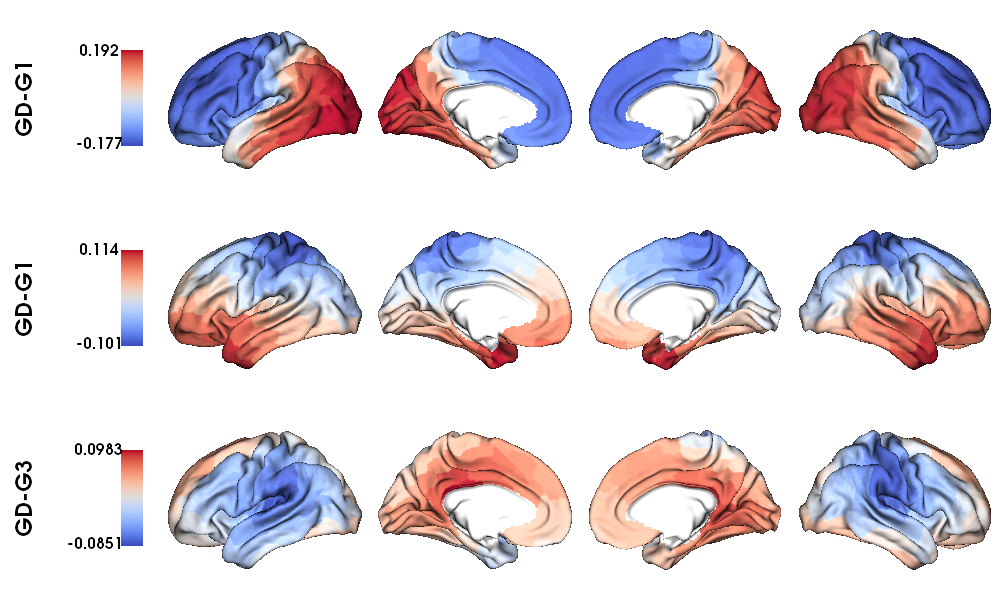

In [174]:
# Left and right gradients concatenated
GD_gradients = np.concatenate((gm_GD_L.gradients_, gm_GD_R.gradients_), axis=0)

# Map gradients to original parcels
grad = [None] * 3
for i, g in enumerate(GD_gradients.T[0:3,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)

# Plot Gradients
plot_hemispheres(c69_lh, c69_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':['GD-G1', 'GD-G1','GD-G3']}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1))